# 回帰（関数）Regression (function)

PyTorchを用いて、何某かの関数を用いて作成したデータセットに対して回帰を行うことを考えます。  
ここでは２入力、２出力のデータに対して回帰をしてみます。  

With PyTorch, we consider performing a regression on a data set created using some function.  
Here we will try to perform regression on data with two inputs and two outputs.  

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pytorchtools import EarlyStopping
import datetime
import os
from torch.utils.tensorboard import SummaryWriter

In [2]:
# 各パラメータの定義
random_seed = 1
test_size = 0.25
num_epochs = 500
batch_size = 16
learning_rate = 0.001
patience = 7 # for early stopping
hidden_size = 16 # 隠れ層のノード数（Number of hidden layer nodes）
dt_start = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
log_dir = f"logs/{dt_start}"

データセットの作成  
使用するデータセットとして２種類を用意しています。  
どちらかのセルを実行してください。  

Creating a Data Set  
Two types of data sets are available for use.  
Please run either cell.  

一つ目：(ファイルより)  
csvファイルに保存されているもので、これはscikit-learnの[make_regression](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html)から作成しています。ノイズやバイアスなど様々なパラメータを使用してデータセットを作成することができます。線形モデルによるデータが出力されます（y = a x1 + b x2 + cという形）。 

First: (from file)  
saved in a csv file, which is from scikit-learn [make_regression](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html). You can create a dataset with various parameters such as noise and bias. The output is data with a linear model (the form of y = a x1 + b x2 + c). 

In [3]:
# データセットの取得その１(ファイルより)
df = pd.read_csv('regression_f2t2.csv', index_col=0)
X = df[['feature0', 'feature1']].values
y = df[['target0', 'target1']].values

二つ目：(計算より)
sinやcos, expなどを組み合わせて作ったデータセットです。  
任意の計算式でデータセットを作成してみてください。  

Second: (from calculation)
This dataset is created by combining sin, cos, exp, etc.  
You can create a dataset with any calculation formula.  

In [4]:
# データセットの取得その２(計算より)
# x1, x2: ±10
n_samples = 5000
x0 = np.random.rand(n_samples)*20 - 10
x1 = np.random.rand(n_samples)*20 - 10
X = np.array([x0, x1]).T

y0 = [10*np.sin(np.sqrt(x0**2 + x1**2)) for x0, x1 in X]
y1 = [np.cos(x0+x1)*np.exp(-(x0**2 + x1**2)/40) for x0, x1 in X]
y = np.array([y0, y1]).T

df = pd.DataFrame(np.concatenate([X, y], axis=1), columns=['feature0', 'feature1', 'target0', 'target1'])

In [5]:
# 3D図で確認
# import plotly.express as px
# px.scatter_3d(df, x='feature0', y='feature1', z='target1', size = [1]*len(df), size_max=10)

In [6]:
# 訓練・テストデータへの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

入力データも出力データもスケールがそれぞれ異なると思われますので、入力と出力の両方を標準化します。  

Both input and output data are expected to be scaled differently, so both input and output data are standardized.  

In [7]:
# 訓練データとテストデータの標準化

# 訓練データの統計量(平均と標準偏差)を保持しておく
SSx = StandardScaler()
SSx.fit(X_train) 
# 入力データの標準化, テストデータの標準化は訓練データの統計量を用いる。
X_train_ss = SSx.transform(X_train)
X_test_ss = SSx.transform(X_test)

# 訓練データの統計量(平均と標準偏差)を保持しておく
SSy = StandardScaler()
SSy.fit(y_train) 
# 入力データの標準化, テストデータの標準化は訓練データの統計量を用いる。
y_train_ss = SSy.transform(y_train)
y_test_ss = SSy.transform(y_test)

データローダ―を訓練データ、テストデータの両方に対して作成します。  
また、[nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)は32bitがサポートされているそうですので、データを32bitであるfloatに変換しておきます。

Create data loaders - for both training and test data.  
Also, since [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is said to support 32bit, convert the data to float, which is 32bit.

In [8]:
# データセットとデータローダ―の作成（訓練データ）

X_train_ss_t = torch.from_numpy(X_train_ss).float() # floatで64でなく32bitにする。
y_train_ss_t = torch.from_numpy(y_train_ss).float()

# データセット
train_ds = TensorDataset(X_train_ss_t, y_train_ss_t)
# データローダ―
torch.manual_seed(random_seed)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [9]:
# データセットとデータローダ―の作成（テストデータ）

X_test_ss_t = torch.from_numpy(X_test_ss).float() # floatで64でなく32bitにする。
y_test_ss_t = torch.from_numpy(y_test_ss).float()

# データセット
test_ds = TensorDataset(X_test_ss_t, y_test_ss_t)
# データローダ―
torch.manual_seed(random_seed)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

モデルを作成します。  
最後の層（出力層）を恒等関数にすることで回帰になります。  
入力層（２ノード）⇒隠れ層１（１６ノード, ReLU）⇒隠れ層２（１６ノード, ReLU）⇒出力層（２ノード, 恒等関数）  

model.  
The last layer (output layer) is made to be an identity function, which is a regression.  
Input layer (2 nodes) ⇒ hidden layer 1 (16 nodes, ReLU) ⇒ hidden layer 2 (16 nodes, ReLU) ⇒ output layer (2 nodes, identity function)  

In [10]:
# ニューラルネットワークのモデル作成

class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)   
        self.layer3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.layer1(x)
        x = nn.functional.relu(x)
        x = self.layer2(x)
        x = nn.functional.relu(x)
        x = self.layer3(x)
        return x

input_size = len(X_train[0]) # 入力サイズは特徴量の個数（２個）
output_size = len(y_train[0]) # 出力サイズは分類する個数（２個）
# インスタンス作成
model = Model(input_size=input_size, output_size=output_size)

損失関数の種類は[loss-functions](https://pytorch.org/docs/stable/nn.html#loss-functions)に記述があります。reductionの説明は[MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)にもあります。ミニバッチ処理では複数のデータをまとめて損失を評価しますが、`sum`のときは複数のデータのトータルの損失値を返します。`mean`のときは１データ当たりの損失値に直して返します。

The types of loss functions are described in [loss-functions](https://pytorch.org/docs/stable/nn.html#loss-functions). The reduction is described in [MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss). The mini-batch process evaluates the loss of multiple data together, but when `sum`, it returns the total loss value of multiple data. When `mean`, it returns the loss value per data.

In [11]:
# 損失関数の定義
#loss_fnc = nn.L1Loss(reduction='mean') # mean absolute error (MAE)
loss_fnc = nn.MSELoss(reduction='mean') # mean squared error (MSE)

[Algorithms](https://pytorch.org/docs/stable/optim.html#algorithms)に最適化手法の種類が記述されています。[Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)などの、詳細な説明もあります。

In [12]:
# 最適化方法の定義
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) # SGD
# optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate) # Adagrad
# optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate) # RMSprop
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [13]:
# 早期終了の定義
early_stopping = EarlyStopping(patience=patience, verbose=False, path=os.path.join(log_dir, 'checkpoint.pt'))

In [14]:
# TensorBoardへ学習条件の記録
writer = SummaryWriter(log_dir)
memo = f"""
epochs: {num_epochs}
batch_size: {batch_size}
learning_ratio: {learning_rate}
patience: {patience}
random_seed: {random_seed}
"""
writer.add_text('regression', memo)

# 学習の開始
loss_hist_train = [0] * num_epochs
accu_hist_train = [0] * num_epochs
loss_hist_test = [0] * num_epochs
accu_hist_test = [0] * num_epochs

for epoch in range(num_epochs):
    
    # training
    model.train() # 訓練モードにする
    for x_batch, y_batch in train_dl:
        optimizer.zero_grad() # 勾配をゼロに戻して初期化
        pred = model(x_batch)
        loss = loss_fnc(pred, y_batch) 
        loss.backward() # 勾配の計算
        optimizer.step() # 重みの更新
        loss_hist_train[epoch] += loss.item() * y_batch.size(0)    
    # 1データ当たりの損失、正解率を計算
    loss_hist_train[epoch] /= len(train_dl.dataset)

    
    # testing
    model.eval() # 評価モードにする
    for x_batch, y_batch in test_dl:
        pred = model(x_batch)
        loss = loss_fnc(pred, y_batch)
        loss_hist_test[epoch] += loss.item() * y_batch.size(0)
    # 1データ当たりの損失、正解率を計算
    loss_hist_test[epoch] /= len(test_dl.dataset)
    
    if epoch % 5 == 0:
        st = f'epoch: {epoch}, '
        st += f'train_loss: {loss_hist_train[epoch]:.3e}, '
        st += f'test_loss: {loss_hist_test[epoch]:.3e}'
        print(st)

    # tensorboard用の出力
    #writer.add_scalar('loss/train', train_loss, epoch)
    #writer.add_scalar('loss/test', val_loss, epoch)
    writer.add_scalars('loss', {'train':loss_hist_train[epoch], 'test':loss_hist_test[epoch]}, epoch) # 複数の値を同一グラフに表示
    writer.add_histogram('lay1_weight', model.layer1.weight, epoch)
    writer.add_histogram('lay1_bias', model.layer1.bias, epoch)
    writer.add_histogram('lay2_weight', model.layer2.weight, epoch)
    writer.add_histogram('lay2_bias', model.layer2.bias, epoch)
    writer.add_histogram('lay3_weight', model.layer3.weight, epoch)
    writer.add_histogram('lay3_bias', model.layer3.bias, epoch)        
    
    # Early Stopping
    early_stopping(loss_hist_test[epoch], model)
    if early_stopping.early_stop:
        print(f'Early stopping occurs at epoch {epoch}')
        break
# もっとも良かったモデルをロードする。
model.load_state_dict(torch.load(early_stopping.path))
writer.close()

epoch: 0, train_loss: 9.963e-01, test_loss: 9.739e-01
epoch: 5, train_loss: 9.215e-01, test_loss: 8.931e-01
epoch: 10, train_loss: 7.767e-01, test_loss: 7.373e-01
epoch: 15, train_loss: 6.141e-01, test_loss: 5.789e-01
epoch: 20, train_loss: 4.460e-01, test_loss: 4.070e-01
epoch: 25, train_loss: 3.158e-01, test_loss: 2.831e-01
epoch: 30, train_loss: 2.398e-01, test_loss: 2.269e-01
epoch: 35, train_loss: 1.969e-01, test_loss: 1.785e-01
epoch: 40, train_loss: 1.656e-01, test_loss: 1.547e-01
epoch: 45, train_loss: 1.450e-01, test_loss: 1.312e-01
epoch: 50, train_loss: 1.257e-01, test_loss: 1.131e-01
epoch: 55, train_loss: 1.156e-01, test_loss: 9.872e-02
epoch: 60, train_loss: 1.031e-01, test_loss: 9.218e-02
epoch: 65, train_loss: 9.450e-02, test_loss: 8.258e-02
epoch: 70, train_loss: 8.712e-02, test_loss: 7.764e-02
epoch: 75, train_loss: 7.843e-02, test_loss: 7.239e-02
epoch: 80, train_loss: 7.125e-02, test_loss: 6.039e-02
epoch: 85, train_loss: 6.702e-02, test_loss: 5.818e-02
epoch: 90, t

学習したモデルで、訓練データとテストデータそれぞれの予測値を算出します。

Calculate predictions for both training and test data using the learned model.

In [15]:
# 予測
model.eval() # 評価モードに変更
# 訓練データ
y_train_ss_t = model(X_train_ss_t) # tensorでの出力
y_train_ss_predict = y_train_ss_t.data.numpy() # numpy配列に変換
# テストデータ
y_test_ss_t = model(X_test_ss_t) # tensorでの出力
y_test_ss_predict = y_test_ss_t.data.numpy() # numpy配列に変換

標準化済みのデータに対して予測値を確認。  

Predictions are checked against standardized data.

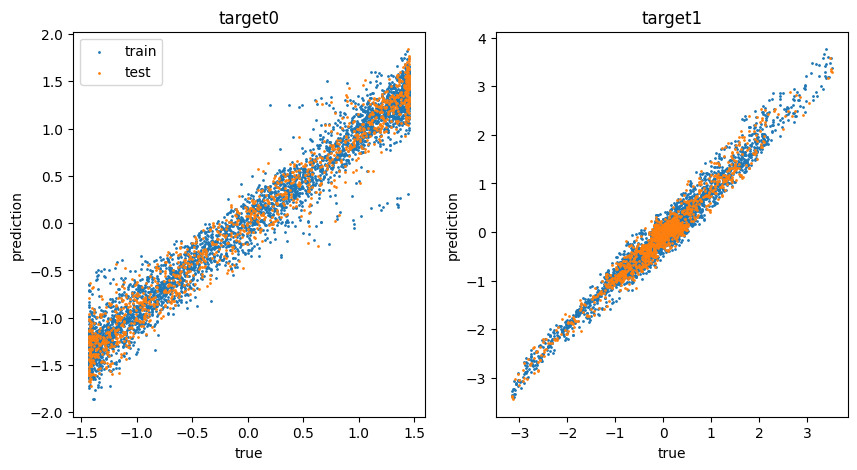

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(y_train_ss[:,0], y_train_ss_predict[:,0], s=1, label='train')
plt.scatter(y_test_ss[:,0], y_test_ss_predict[:,0], s=1, label='test')
plt.xlabel('true')
plt.ylabel('prediction')
plt.title('target0')
plt.legend()
plt.subplot(122)
plt.scatter(y_train_ss[:,1], y_train_ss_predict[:,1], s=1, label='train')
plt.scatter(y_test_ss[:,1], y_test_ss_predict[:,1], s=1, label='test')
plt.xlabel('true')
plt.title('target1')
plt.ylabel('prediction')
plt.show()

元のスケールに戻して予測値を確認  

Return to original scale and check predicted values  

In [17]:
y_train_predict = SSy.inverse_transform(y_train_ss_predict)
y_test_predict = SSy.inverse_transform(y_test_ss_predict)

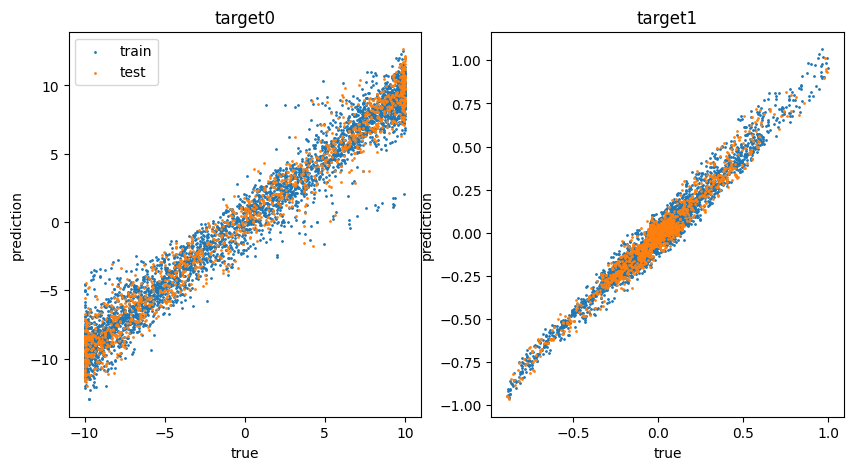

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(y_train[:,0], y_train_predict[:,0], s=1, label='train')
plt.scatter(y_test[:,0], y_test_predict[:,0], s=1, label='test')
plt.xlabel('true')
plt.ylabel('prediction')
plt.title('target0')
plt.legend()
plt.subplot(122)
plt.scatter(y_train[:,1], y_train_predict[:,1], s=1, label='train')
plt.scatter(y_test[:,1], y_test_predict[:,1], s=1, label='test')
plt.xlabel('true')
plt.title('target1')
plt.ylabel('prediction')
plt.show()

問題：  
損失が減少していく過程（学習過程）をTensorBoardを用いて確認してください。  
また学習に用いたパラメータ（レイヤー数やノード数、学習率など）を変えて実行してみて、学習過程がどのように変化するかを確認してください。  
その上で、損失が最も小さくなるようなパラメータを探索してみてください。 

Question:  
Check the process of decreasing loss (learning process) using TensorBoard.  
Also, try running the simulation with different parameters used for learning (number of layers, number of nodes, learning rate, etc.) and see how the learning process changes.  
Then, try to find the parameters that minimize the loss. 